**MEDICAL COSTS - INSURANCE COST**

Problem Description - 

* **Source**  - https://www.kaggle.com/mirichoi0218/insurance
* **Data** - Prediction of Insurance Cost for a person given features like Age, Sex, Smoking, Region etc.


In [1]:
# Import libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np

In [2]:
# Read the dataset

raw_format_url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'

df = pd.read_csv(raw_format_url)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Data Volume
df.shape

(1338, 7)

### EDA

Let's look what exactly is in the dataset

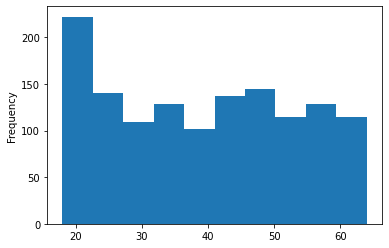

In [4]:
# How is age distributed?
df['age'].plot.hist(bins=10)

In [5]:
# Fairly even, with a slightly higher number of younger people

In [6]:
# How is sex distributed?
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [7]:
# Fairly even dataset across genders

> From Wiki -  Commonly accepted BMI ranges are underweight (under 18.5 kg/m2), normal weight (18.5 to 25), overweight (25 to 30), and obese (over 30). 

> As mentioned on Github, this data is for the US and the CDC also follows the same [guidelines](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html) for BMI - 

Let's see how the BMI is distributed

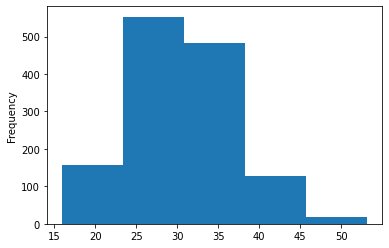

In [8]:
df['bmi'].plot.hist(bins=5)

In [9]:
# Interesting.... a large chunk of the data is having a higher BMI!

In [10]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [11]:
# Majority of the people have <= 2 children

In [12]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [13]:
# More non-smokers. Is the cost of insurance higher for smokers?

no_of_smokers = df[df['smoker'] == 'yes'].shape[0]
no_of_non_smokers = df[df['smoker'] == 'no'].shape[0]

avg_cost_for_smokers = df[df['smoker'] == 'yes']['charges'].sum() / no_of_smokers
avg_cost_for_non_smokers = df[df['smoker'] == 'no']['charges'].sum() / no_of_non_smokers

print("Average insurance cost for Smokers : ", avg_cost_for_smokers)
print("Average insurance cost for Non-Smokers : ", avg_cost_for_non_smokers)

Average insurance cost for Smokers :  32050.23183153284
Average insurance cost for Non-Smokers :  8434.268297856204


In [14]:
# Yeah, thought so!

In [15]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [16]:
# Fairly even distribution across regions

In [17]:
# Let's see if cost incured by distinct values in a feature are uniform

def charges_per_category(df, category, plot = True):
  """
  Function to get average charge across distinct values in a category
  """
  grouped_df = df.groupby([category])[['charges']].mean()

  if plot:
    grouped_df['charges'].plot()
  else:
    return grouped_df

In [18]:
# Average cost of insurance across regions
charges_per_category(df, 'region', plot = False)

,charges
region,
northeast,13406.384516
northwest,12417.575374
southeast,14735.411438
southwest,12346.937377


In [19]:
# Southeast is paying highest cost. Does it have higher number of smokers?
pd.crosstab(df['region'], df['smoker']) 

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


In [20]:
# Yes, it does!!

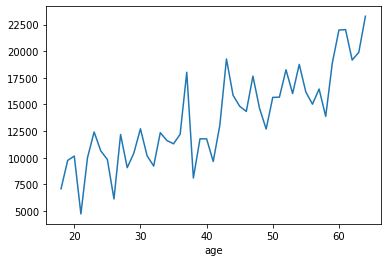

In [21]:
# Average cost of insurance by the age
charges_per_category(df, 'age', plot = True)

In [22]:
# Figure shows an upward trend. This is how insurance works, right?

In [23]:
# Average cost of insurance by the sex
charges_per_category(df, 'sex', plot = False)

,charges
sex,
female,12569.578844
male,13956.751178


In [24]:
# Males are paying, on an avg, $1000 more for the insurance

In [25]:
# Do you pay less insurance, if you have better BMI?

# Let's first assign a category based on CDC guidelines to BMI range
# BMI	            Weight Status
# Below 18.5	    Underweight
# 18.5 – 24.9	    Normal or Healthy Weight
# 25.0 – 29.9	    Overweight
# 30.0 and Above	Obese

df_bmi = df[['bmi', 'charges']]
df_bmi['bmi_category'] = pd.cut(df['bmi'],[0, 18.5, 24.9, 29.9, np.inf],labels=['Underweight','Normal or Healthy Weight', 'Overweight', 'Obese'])

charges_per_category(df_bmi, 'bmi_category', plot = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,charges
bmi_category,
Underweight,8657.620652
Normal or Healthy Weight,10404.900084
Overweight,11006.809989
Obese,15491.542238


In [26]:
# In an ideal world, Underweight people would pay more for the insurance

## Data Preparation

In [27]:
# Since we have few categorical columns, let's first one-hot encode the dataframe

one_hot_df = pd.get_dummies(df)
one_hot_df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [28]:
# Now that all the features are numeric, we can create features and labels
X, y = one_hot_df.drop(columns=['charges'], axis=1), one_hot_df['charges']

# Next, we need to split the data in train and test. We can ignore validation, due to less data size. We'll choose 20% testing data

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

## Modelling

In [29]:
tf.random.set_seed(42)
# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 50, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 6058.5903 - mae: 6058.5903


In [30]:
# Our model is off by 6k. What are central tendencies of y_test?
y_test.median(), y_test.mean()

(8487.8803, 12968.31706286941)

In [31]:
# Compared to mean and median, the model loss is substantial and needs a lot of improvement

### Experiments

In [32]:
# Experiment 1 - Change the learning rate to default

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 50, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 6288.8306 - mae: 6288.8306


In [33]:
# Even worse, so we might need to increase the LR

# Experiment 2 - Increase the learning rate

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 50, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 2260.5576 - mae: 2260.5576


In [34]:
# Woahhh!! That's a good jump. Now, we can look into epochs

# Experiment 3 - Increase the epochs. Note that we have carried LR from previous experiment

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 1879.9004 - mae: 1879.9004


In [35]:
# Even better. One question we might ask is, are we overfitting the data?

# Experiment 4 - Reduce the number of hidden layers

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 1ms/step - loss: 2137.7402 - mae: 2137.7402


In [36]:
# Experiment 5 - Increase the number of neurons in hidden layers

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
model.fit(X_train, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 1835.4792 - mae: 1835.4792


In [37]:
# A little improvement. What we are trying till now is looking only at test accuracy. What about training accuracy?

model.evaluate(X_train, y_train)

# So, the model is performing better on test data ?!?!?!?

34/34 [==============================] - 0s 1ms/step - loss: 2110.1436 - mae: 2110.1436


[2110.1435546875, 2110.1435546875]

In [38]:
# Experiment 6 - Let's try a different architecture. Also, we will also plot history

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
history = model.fit(X_train, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model on both train and test data set
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step - loss: 1661.8612 - mae: 1661.8612


In [39]:
# Again, improvement. But, test accuracy is still higher than train accuracy. Are we training our model less? 
# 500 epochs for a 1000 row dataset seems enough

# Let's check out history metrics

Text(0, 0.5, 'Loss')

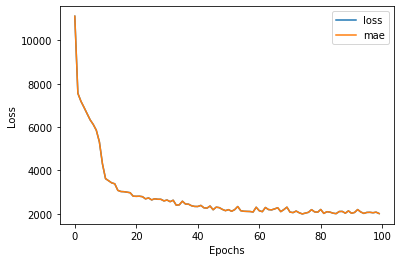

In [40]:
# Plot history (Also known as loss curve or training curve)

pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [41]:
# So, the answer is, absolutely not. Model training mostly happens till 100 epochs and then it's all diminishing returns.
# In order to further decrease the loss, let's try out other approaches, becuase let's face it, 2000 is still a substantial loss
# $2000, is a LOT MORE!!

In [42]:
# Let's have a look at the data again.
X_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
560,46,19.95,2,1,0,1,0,0,1,0,0
1285,47,24.32,0,1,0,1,0,1,0,0,0
1142,52,24.86,0,1,0,1,0,0,0,1,0
969,39,34.32,5,1,0,1,0,0,0,1,0
486,54,21.47,3,1,0,1,0,0,1,0,0


In [43]:
print("Age Range : ", min(df['age']), '-', max(df['age']))
print("BMI Range : ", min(df['bmi']), '-', max(df['bmi']))

Age Range :  18 - 64
BMI Range :  15.96 - 53.13


### Feature Scaling

In [44]:
# We can see the Age range and BMI range are very far from 0-1 range. Also, no. of children is in range [0,5]
# Although the model will take care of this and assign appropriate weights, but it might be worthwhile to scale the features

In [45]:
# Read the dataset

raw_format_url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'

df = pd.read_csv(raw_format_url)

# Now that all the features are numeric, we can create features and labels
X, y = df.drop(columns=['charges'], axis=1), df['charges']

# Next, we need to split the data in train and test. We can ignore validation, due to less data size. We'll choose 20% testing data
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
)

# # Fit transform the column transform to train and test dataset
# X_train_transformed = ct.fit_transform(X_train)
# X_test_transformed = ct.fit_transform(X_test)

# fitting column transformer on training data
ct.fit(X_train)

# transforming training and test data with normalizing (MinMaxScaler) and one hot encodig (OneHotEncoder)
X_train_transformed = ct.transform(X_train)
X_test_transformed = ct.transform(X_test)

9/9 [==============================] - 0s 1ms/step - loss: 1756.3867 - mae: 1756.3867


Text(0, 0.5, 'Loss')

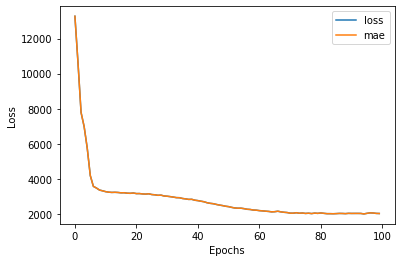

In [46]:
# Let's run the experiment again

# Experiment 7 - Data Scaling and removing redundant features

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
history = model.fit(X_train_transformed, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model on both train and test data set
model.evaluate(X_train_transformed, y_train)
model.evaluate(X_test_transformed, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test_transformed)


# Plot history (Also known as loss curve or training curve)

pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

9/9 [==============================] - 0s 2ms/step - loss: 1736.9994 - mae: 1736.9994


Text(0, 0.5, 'Loss')

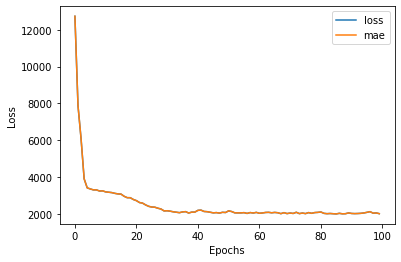

In [47]:
# No significant improvement. Let's add layers

# Experiment 8 - 5 layered DNN

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
history = model.fit(X_train_transformed, y_train, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model on both train and test data set
model.evaluate(X_train_transformed, y_train)
model.evaluate(X_test_transformed, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test_transformed)


# Plot history (Also known as loss curve or training curve)

pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

9/9 [==============================] - 0s 2ms/step - loss: 1856.5214 - mae: 1856.5214


Text(0, 0.5, 'Loss')

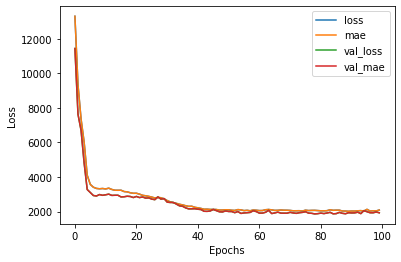

In [48]:
# Still not adding much value. Let's try Validation

# Experiment 9 - Validation Splits

# Step 1 - Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['mae'])

# Step 3 - Fit the model
history = model.fit(X_train_transformed, y_train, validation_split=0.2, epochs = 100, verbose = 0)

# Step 4 - Evaluate the model on both train and test data set
model.evaluate(X_train_transformed, y_train)
model.evaluate(X_test_transformed, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test_transformed)


# Plot history (Also known as loss curve or training curve)

pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

9/9 [==============================] - 0s 2ms/step - loss: 1314.2181 - mae: 1314.2181


Text(0, 0.5, 'Loss')

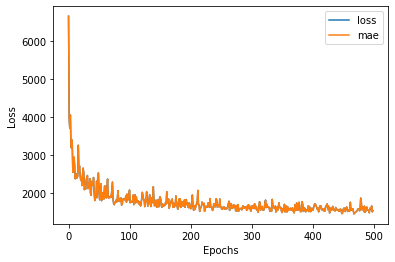

In [49]:
# Still not adding much value. Let's try Validation

# Experiment 10 - Deeper model

# Step 1 - Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(200, activation = tf.keras.activations.relu),
    # tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
])

# Step 2 - Compile the model
model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.05),
              metrics = ['mae'])

# Step 3 - Fit the model
history = model.fit(X_train_transformed, y_train,  epochs = 500, verbose = 0)

# Step 4 - Evaluate the model on both train and test data set
model.evaluate(X_train_transformed, y_train)
model.evaluate(X_test_transformed, y_test)

# Step 5 - Make predictions
y_pred = model.predict(X_test_transformed)


# Plot history (Also known as loss curve or training curve)

pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [50]:
# Best model yet. Although looks like overkill using this architecture and 500 epochs, but gives better results